## Setup

Please execute the cell(s) below to initialize the notebook environment.

In [ ]:
# @title Install dependencies
# !pip install poetry

In [ ]:
# @title Install SMorph Python module
# !pip install https://github.com/swanandlab/SMorph/releases/download/v0.1.1-alpha/SMorph-0.1.1.tar.gz

In [1]:
# Imports
on_colab = 'google.colab' in str(get_ipython())

import warnings
warnings.filterwarnings('ignore')

if not on_colab:
    import napari
import smorph as sm
import smorph.util.autocrop as ac
import ipywidgets as widgets

In [2]:
# Helper function
def view_3D(*args):
    """Views a 3D image."""
    n_images = len(args)
    if not on_colab and n_images > 0:
        with napari.gui_qt():
            viewer = napari.view_image(**args[0], ndisplay=3)
            for itr in range(1, n_images):
                if args[itr]['data'].max() > 1 and args[itr]['data'].max() % 1 == 0:
                    if 'colormap' in args[itr].keys():
                        del args[itr]['colormap']
                    if 'gamma' in args[itr].keys():
                        del args[itr]['gamma']
                    viewer.add_labels(**args[itr])
                else:
                    viewer.add_image(**args[itr])

---

## Step 1: Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.
- Followed by non-local means denoising using auto-calibrated parameters

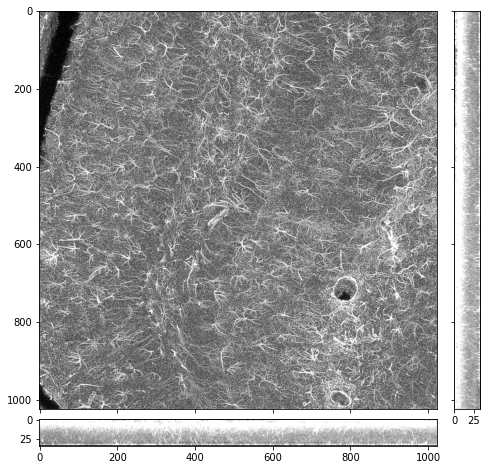

In [3]:
CONFOCAL_TISSUE_IMAGE = 'Datasets/Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_21 DAYS/CONTROLS_CZI/MSPP2.1MA_1_SINGLE MARK _CTRL_21 DAY/MSP2.1MA_1_SINGLE MARK_20X_SEC 1_RIGHT_HILUS.czi'  #@param

original = ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE)

if original.ndim == 2:
  original = (original - original.min()) / (original.max() - original.min())
  import numpy as np
  original = np.expand_dims(original, 0)

CLIP_LIMIT = .03
# Adaptive Equalization
from skimage import exposure
original = exposure.equalize_adapthist(original, clip_limit=CLIP_LIMIT)
original = ac.deconvolve(original, CONFOCAL_TISSUE_IMAGE)
ac.projectXYZ(original, .5, .5, 1)

In [ ]:
view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
{'data': ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE), 'colormap': 'gray', 'name': 'rww'})

---

## Step 2: Select ROI using Polygonal Lasso Tool

Set two variables:
- `SELECT_ROI`: True, If you want to select ROI manually; else False
- `NAME_ROI`: Name of the manually selected ROI
- `FILE_ROI`: Path to the ROI file; else None

In [4]:
SELECT_ROI = True
NAME_ROI = 'ML'
FILE_ROI = 'Datasets/Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_21 DAYS/CONTROLS_CZI/MSPP2.1MA_1_SINGLE MARK _CTRL_21 DAY/MSP2.1MA_1_SINGLE MARK_20X_SEC 1_RIGHT_HILUS-ML.roi'
linebuilder = None
import matplotlib.pyplot as plt
%matplotlib widget

IMG_NAME = CONFOCAL_TISSUE_IMAGE.split('/')[-1].split('.')[0]

import matplotlib.pyplot as plt
file_roi_widget = widgets.Text(value=FILE_ROI, description='file_roi')
def roi_interact(select_roi=SELECT_ROI,
                 name_roi=NAME_ROI, draw_roi=False, file_roi=FILE_ROI):
  global SELECT_ROI, NAME_ROI, FILE_ROI, linebuilder, file_roi_widget
  SELECT_ROI, NAME_ROI, FILE_ROI = select_roi, name_roi, file_roi
  NAME_ROI = NAME_ROI if SELECT_ROI else ''
  if draw_roi:
    FILE_ROI = None
    file_roi_widget.layout.visibility = 'hidden'
  else:
    file_roi_widget.value = FILE_ROI
    file_roi_widget.layout.visibility = 'visible'
    plt.clf()
  linebuilder = None if not SELECT_ROI else ac.select_ROI(original, IMG_NAME + '-' + NAME_ROI, FILE_ROI)


_ = widgets.interact(roi_interact, select_roi=SELECT_ROI,
                     name_roi=NAME_ROI, draw_roi=False, file_roi=file_roi_widget)

interactive(children=(Checkbox(value=True, description='select_roi'), Text(value='ML', description='name_roi')…

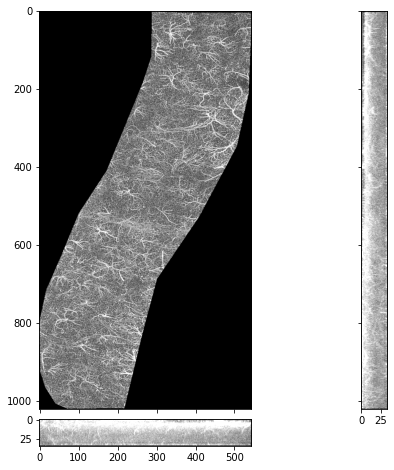

In [5]:
%matplotlib inline
if SELECT_ROI:
    original, _ = ac.mask_ROI(original, original, linebuilder)
    ac.projectXYZ(original, .5, .5, 1)

In [6]:
#installed windows sdk
# !pip install cvxpy cvxopt
import numpy as np
import cvxpy
import cvxopt
from shapely.geometry import Polygon


def rect2poly(ll, ur):
    """
    Convert rectangle defined by lower left/upper right
    to a closed polygon representation.
    """
    x0, y0 = ll
    x1, y1 = ur

    return [
        [x0, y0],
        [x0, y1],
        [x1, y1],
        [x1, y0],
        [x0, y0]
    ]


def get_intersection(coords):
    """Given an input list of coordinates, find the intersection
    section of corner coordinates. Returns geojson of the
    interesection polygon.
    """
    ipoly = None
    for coord in coords:
        if ipoly is None:
            ipoly = Polygon(coord)
        else:
            tmp = Polygon(coord)
            ipoly = ipoly.intersection(tmp)

    # close the polygon loop by adding the first coordinate again
    first_x = ipoly.exterior.coords.xy[0][0]
    first_y = ipoly.exterior.coords.xy[1][0]
    ipoly.exterior.coords.xy[0].append(first_x)
    ipoly.exterior.coords.xy[1].append(first_y)

    inter_coords = zip(
        ipoly.exterior.coords.xy[0], ipoly.exterior.coords.xy[1])

    inter_gj = {"geometry":
                {"coordinates": [inter_coords],
                 "type": "Polygon"},
                 "properties": {}, "type": "Feature"}

    return inter_gj, inter_coords


def two_pts_to_line(pt1, pt2):
    """
    Create a line from two points in form of
    a1(x) + a2(y) = b
    """
    pt1 = [float(p) for p in pt1]
    pt2 = [float(p) for p in pt2]
    try:
        slp = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    except ZeroDivisionError:
        slp = 1e5 * (pt2[1] - pt1[1])
    a1 = -slp
    a2 = 1.
    b = -slp * pt1[0] + pt1[1]

    return a1, a2, b


def pts_to_leq(coords):
    """
    Converts a set of points to form Ax = b, but since
    x is of length 2 this is like A1(x1) + A2(x2) = B.
    returns A1, A2, B
    """

    A1 = []
    A2 = []
    B = []
    for i in range(len(coords) - 1):
        pt1 = coords[i]
        pt2 = coords[i + 1]
        a1, a2, b = two_pts_to_line(pt1, pt2)
        A1.append(a1)
        A2.append(a2)
        B.append(b)
    return A1, A2, B


def get_maximal_rectangle(coordinates):
    """
    Find the largest, inscribed, axis-aligned rectangle.
    :param coordinates:
        A list of of [x, y] pairs describing a closed, convex polygon.
    """

    coordinates = np.array(coordinates)
    x_range = np.max(coordinates, axis=0)[0]-np.min(coordinates, axis=0)[0]
    y_range = np.max(coordinates, axis=0)[1]-np.min(coordinates, axis=0)[1]

    scale = np.array([x_range, y_range])
    sc_coordinates = coordinates/scale

    poly = Polygon(sc_coordinates)
    inside_pt = (poly.representative_point().x,
                 poly.representative_point().y)

    A1, A2, B = pts_to_leq(sc_coordinates)

    bl = cvxpy.Variable(2)
    tr = cvxpy.Variable(2)
    br = cvxpy.Variable(2)
    tl = cvxpy.Variable(2)
    obj = cvxpy.Maximize(cvxpy.log(tr[0] - bl[0]) + cvxpy.log(tr[1] - bl[1]))
    constraints = [bl[0] == tl[0],
                   br[0] == tr[0],
                   tl[1] == tr[1],
                   bl[1] == br[1],
                   ]

    for i in range(len(B)):
        if inside_pt[0] * A1[i] + inside_pt[1] * A2[i] <= B[i]:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] <= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] <= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] <= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] <= B[i])

        else:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] >= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] >= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] >= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] >= B[i])

    prob = cvxpy.Problem(obj, constraints)
    prob.solve()#prob.solve(solver=cvxpy.SCIPY, verbose=False, max_iters=1000, reltol=1e-9)

    bottom_left = np.array(bl.value).T * scale
    top_right = np.array(tr.value).T * scale

    return bottom_left, top_right#list(bottom_left[0]), list(top_right[0])

In [7]:
_, coordinates = get_intersection([linebuilder])
# print(np.array((list(coordinates))))
# get the maximally inscribed rectangle
ll, ur = get_maximal_rectangle(np.array((list(coordinates))))

In [8]:
ll, ur = np.ceil(ll).astype(int), np.floor(ur).astype(int)
llx, lly = ll; urx, ury = ur
llx -= linebuilder[:, 0].min(); urx -= linebuilder[:, 0].min()
lly -= linebuilder[:, 1].min(); ury -= linebuilder[:, 1].min()
lly, llx, ury, urx

(238, 284, 489, 344)

In [9]:
# from skimage.morphology import closing
# denoised = closing(original)
# deconvolved = ac.deconvolve(original, CONFOCAL_TISSUE_IMAGE, iters=2)
denoiser = ac.calibrate_nlm_denoiser(original[:, lly:ury, llx:urx])
denoise_parameters = denoiser.keywords['denoiser_kwargs']
print(denoise_parameters)
denoised = ac.denoise(original, denoise_parameters)
# deconvolved = ac.deconvolve(denoised, CONFOCAL_TISSUE_IMAGE, iters=1)

{'h': 0.09570487404931702, 'patch_size': 2, 'patch_distance': 5}


In [10]:
import imagej
import scyjava
scyjava.config.add_option('-Xmx6g')
ij = imagej.init('C:/Program Files (x86)/Fiji.app', headless=False)
from scyjava import jimport
WindowManager = jimport('ij.WindowManager')

In [31]:
# You need to specify that no changes have been made, or else
# the close window dialogue at the end will ask for confirmation.
ij.ui().show('denoised', ij.py.to_java(np.expand_dims(original, axis=1)))
img = WindowManager.getCurrentImage()
img.changes = False

In [32]:
plugin = '3D Fast Filters'

args = { 
    'filter': 'Median',  # StringField
    'radius_x_unit': .6918883015525974,  # NumericField
    'radius_x_pix': 1,  # NumericField
    'radius_y_unit': .6918883015525974,  # NumericField
    'radius_y_pix': 1,  # NumericField
    'radius_z_unit': 1.0785801681301463,
    'radius_z_pix': 1
}

ij.py.run_plugin(plugin, args)#, ij1_style=False)
result = WindowManager.getCurrentImage()
result = ij.py.from_java(result).to_numpy()
result.shape

(34, 1020, 544)

In [28]:
plugin = 'Tubeness'

args = {
    'sigma': .691884765625
}

ij.py.run_plugin(plugin, args)#, ij1_style=False)
result = WindowManager.getCurrentImage()
result_array = ij.py.from_java(result)
view_3D({'data': result_array, 'colormap': 'gray', 'name': 'result_array'},
        {'data': denoised, 'colormap': 'gray', 'name': 'denoised'})

2021-11-02 19:36:11,073 [INFO] WRITING LOG OUTPUT TO C:\Users\SwanandLab\.cellpose\run.log


In [35]:
denoiser = ac.calibrate_nlm_denoiser(result[:, lly:ury, llx:urx])
denoise_parameters = denoiser.keywords['denoiser_kwargs']
print(denoise_parameters)
denoised = ac.denoise(result, denoise_parameters)

{'h': 0.04522776387282544, 'patch_size': 4, 'patch_distance': 2}


In [36]:
view_3D({'data': result, 'colormap': 'gray', 'name': 'result_array'},
        {'data': denoised, 'colormap': 'gray', 'name': 'denoised'})

2021-11-02 19:43:27,480 [ERROR] Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\jupyter_client\threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
2021-11-02 19:43:27,487 [ERROR] Unc

In [26]:
# import tifffile
# tifffile.imwrite('temp_C001T001.tif', denoised)

---

## Step 3: Segmentation

### 3.1 Threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

Understand their effect by configuring three parameters:
- `LOW_DELTA`: Pixel intensity value corresponding to change in `LOW_THRESH`
- `HIGH_DELTA`: Pixel intensity value corresponding to change in `HIGH_THRESH`
- `N_STEPS`: Number of steps of delta in threshold to take in both directions

In [37]:
import skimage
otsu_value = skimage.filters.threshold_otsu(denoised)
print(otsu_value)

LOW_THRESH = .34
HIGH_THRESH = .4

LOW_DELTA = .01
HIGH_DELTA = .01
N_STEPS = 1
results = None
%matplotlib inline
def test_thresholds(low_thresh_init, low_thresh, high_thresh_init,
                    high_thresh, low_delta, high_delta, n_steps):
  global results, LOW_THRESH, HIGH_THRESH, LOW_DELTA, HIGH_DELTA, N_STEPS
  LOW_THRESH, HIGH_THRESH, N_STEPS = low_thresh, high_thresh, n_steps
  if low_thresh_init is not None:
    LOW_THRESH = eval(f'skimage.filters.threshold_{low_thresh_init}(denoised)')
  if high_thresh_init is not None:
    if high_thresh_init == 'isodata':
      HIGH_THRESH = eval(f'skimage.filters.threshold_{high_thresh_init}(denoised)')
  LOW_DELTA, HIGH_DELTA = low_delta, high_delta
  results = ac.testThresholds(denoised, LOW_THRESH, HIGH_THRESH, LOW_DELTA,
                              HIGH_DELTA, N_STEPS, 'gist_earth')

_ = widgets.interact(test_thresholds,
                     low_thresh_init=[None, *sm.util.THRESHOLD_METHODS],
                     low_thresh=widgets.FloatSlider(LOW_THRESH, min=0, max=1, step=.01,
                                                    readout_format='.4f', layout=widgets.Layout(width='100%')),
                     high_thresh_init=[None, *sm.util.THRESHOLD_METHODS],
                     high_thresh=widgets.FloatSlider(HIGH_THRESH, min=0, max=1, step=.01,
                                                     readout_format='.4f', layout=widgets.Layout(width='100%')),
                     low_delta=widgets.FloatSlider(LOW_DELTA, min=0, max=1, step=.0005,
                                                   readout_format='.4f', layout=widgets.Layout(width='100%')),
                     high_delta=widgets.FloatSlider(HIGH_DELTA, min=0, max=1, step=.0005,
                                                    readout_format='.4f', layout=widgets.Layout(width='100%')),
                     n_steps=widgets.IntSlider(N_STEPS, min=0, max=10,
                                               layout=widgets.Layout(width='100%'))
)

0.181640625


interactive(children=(Dropdown(description='low_thresh_init', options=(None, 'isodata', 'li', 'mean', 'minimum…

(array([51066., 50011., 49456., ...,    61.,    92.,  2227.]),
 array([0.10000007, 0.10087897, 0.10175788, ..., 0.99824219, 0.99912109,
        1.        ]),
 <BarContainer object of 1024 artists>)

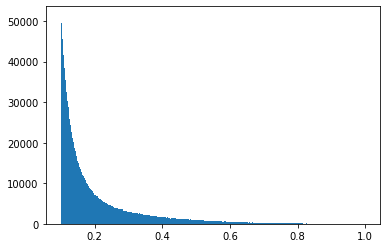

In [64]:
plt.hist(abc.ravel()[abc.ravel()>0], bins=1024)

In [66]:
abc = denoised.copy()
abc[abc <= .2] = 0
view_3D({'data': abc, 'colormap': 'inferno', 'name': 'original'}, {'data': denoised, 'colormap': 'inferno', 'name': 'original'})

2021-11-02 21:06:22,309 [ERROR] Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\jupyter_client\threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
2021-11-02 21:06:22,310 [ERROR] Unc

In [42]:
view_3D({'data': denoised, 'colormap': 'inferno', 'name': 'original'}, *results)

2021-11-02 20:45:25,817 [ERROR] Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\jupyter_client\threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
2021-11-02 20:45:25,831 [ERROR] Unc

In [13]:
thresholded = ac.threshold(denoised, LOW_THRESH, HIGH_THRESH)
labels = ac.label_thresholded(thresholded)

In [14]:
prefiltering_volume = thresholded.sum()
f'Prefiltering Volume: {prefiltering_volume}'

'Prefiltering Volume: 403969'

### 3.2 Filter segmented individual cells by removing ones in borders (touching the convex hull)

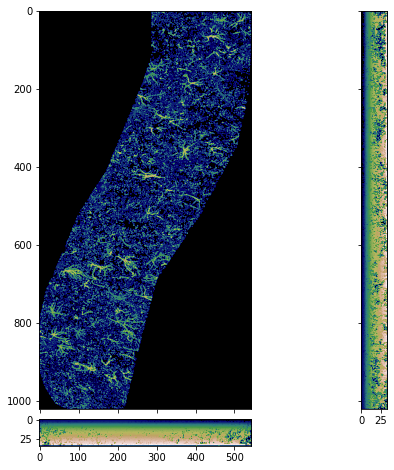

In [15]:
# discard objects connected to border of approximated tissue, potential partially captured
# filtered_labels = ac.filter_labels(labels, thresholded, linebuilder) if original.shape[0] > 1 else labels
filtered_labels = labels
ac.projectXYZ(filtered_labels, .5, .5, 1, 'gist_earth')

In [16]:
view_3D({'data': denoised, 'colormap': 'red', 'name': 'denoised'},
        {'data': filtered_labels, 'colormap': 'gray', 'gamma': .8, 'name': 'filtered_labels'},
        {'data': labels, 'colormap': 'gist_earth', 'gamma': .8, 'name': 'labels'})

2021-11-02 17:15:06,741 [ERROR] Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\jupyter_client\threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
2021-11-02 17:15:06,742 [ERROR] Unc

In [17]:
# get the centroids and label values from the label image
regions = ac.arrange_regions(filtered_labels)
regions = sorted(regions, key= lambda r: [r.centroid[2], r.centroid[1], r.centroid[0]])

centroid_coords = [r.centroid for r in regions]

# store the labels for each blob in a properties dictionary
pts_properties = {'obj': [i for i in range(len(regions))]}

### 3.3 Visualize segmented cells to determine cutoff volumes

#### 3.3.1 Check segmented cells on whole image

In [18]:
import numpy as np
from smorph.analysis._skeletal import _get_blobs

somas_estimates = []

i = 0
for region in regions:
    minz, miny, minx, maxz, maxy, maxx = region.bbox
    try:
        blobs = _get_blobs(denoised[minz:maxz, miny:maxy, minx:maxx] * region.image, 'confocal')
        consistent_blob = blobs[blobs[:, 3].argsort()][0].astype(int)[:-1]
        ll = np.array([minz, miny, minx])  # lower-left
        somas_estimates.append(ll + consistent_blob)
    except:
        somas_estimates.append(region.centroid)
len(somas_estimates)

224

## If rechecking

In [ ]:
# somas_estimates = np.load('somas_estimates-ML.npy')

In [21]:
reconstructed_labels = np.zeros(original.shape, dtype=int)
for itr in range(len(regions)):
    minz, miny, minx, maxz, maxy, maxx = regions[itr].bbox
    reconstructed_labels[minz:maxz, miny:maxy, minx:maxx] += regions[itr].image * (itr + 1)

centroid_coords = [r.centroid for r in regions]

# store the labels for each blob in a properties dictionary
pts_properties = {'obj': [i for i in range(len(regions))]}

if not on_colab:
    with napari.gui_qt():
        man_viewer = napari.view_image(denoised, ndisplay=3)
        man_viewer.add_labels(reconstructed_labels, rendering='translucent', opacity=.4)
        man_viewer.add_points(somas_estimates, face_color='red', size=5, symbol='ring')
        man_viewer.add_points(centroid_coords, edge_color='transparent',
                          face_color='transparent',
                          properties=pts_properties, text='obj')

2021-11-02 17:23:04,587 [ERROR] Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\SwanandLab\AppData\Local\pypoetry\Cache\virtualenvs\smorph-ObnBYCc1-py3.7\lib\site-packages\jupyter_client\threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "c:\users\swanandlab\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running
2021-11-02 17:23:04,588 [ERROR] Unc

In [ ]:
from os import listdir, path

import numpy as np
import tifffile
from skimage.measure import label
from smorph.util.autocrop._io import _build_multipoint_roi
from smorph.util.autocrop._postprocessing import _segment_clump

somas_estimates = np.unique(man_viewer.layers[2].data, axis=0)
filtered_regions, residue = [], []
separated_clumps = []

print('Please recheck if you REALLY want these changes.')

itr = 0
for region in regions:
    minz, miny, minx, maxz, maxy, maxx = region.bbox
    ll = np.array([minz, miny, minx])  # lower-left
    ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
    inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
    somas_coords = somas_estimates[inidx].astype(np.int64)

    if len(somas_coords) == 0:
        print('Delete region:', itr)
        residue.append(region)
    elif len(np.unique(somas_coords.astype(int), axis=0)) > 1:  # clumpSep
        somas_coords = somas_coords.astype(int)
        somas_coords -= ll
        im = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
        im[~region.image] = 0
        markers = np.zeros(region.image.shape)

        somas_coords = np.array([x for x in somas_coords if region.image[tuple(x)] > 0])

        if len(somas_coords) == 0:  # no marked point ROI
            print('Delete region:', itr)
        
        if somas_coords.shape[0] == 1:
            filtered_regions.append(region)
            continue

        for i in range(somas_coords.shape[0]):
            markers[tuple(somas_coords[i])] = i + 1
            separated_clumps.append(somas_coords[i])

        labels = _segment_clump(im, markers)
        separated_regions = ac.core.arrange_regions(labels)
        for r in separated_regions:
            r.slice = (slice(minz + r.bbox[0], minz + r.bbox[3]),
                       slice(miny + r.bbox[1], miny + r.bbox[4]),
                       slice(minx + r.bbox[2], minx + r.bbox[5]))
        print('Split clump region:', itr)
        filtered_regions.extend(separated_regions)
    else:
        filtered_regions.append(region)
    itr += 1

### Confirm changes

In [ ]:
regions = sorted(filtered_regions, key=lambda region: region.area)

In [ ]:
somas_estimates = np.vstack((somas_estimates, np.load('rejected_clumps-ML.npy')))

### After all changes

In [ ]:
np.save('somas_estimates-ML.npy', somas_estimates)

np.save('rejected_clumps-ML.npy', np.setdiff1d(somas_coords, separated_clumps))  # discarded clump ROI: to be subtracted

#### 3.3.2: Check batches of objects

In [ ]:
# Set `BATCH_NO` to view detected objects in paginated 2D MIP views.
N_BATCHES = ac.paginate_objs(regions, pg_size=50)

def plot_batch(BATCH_NO):
  ac.project_batch(BATCH_NO, N_BATCHES, regions, denoised)
  plt.show()

_ = widgets.interact(plot_batch, BATCH_NO=widgets.IntSlider(min=0,
                       max=N_BATCHES-1, layout=widgets.Layout(width='100%')))

#### 3.3.2: Check individual objects
Select individual objects using `OBJ_INDEX`.

In [ ]:
OBJ_INDEX = 0
extracted_cell = None
minz, miny, minx, maxz, maxy, maxx = 0, 0, 0, 0, 0, 0

def plot_single(obj_index):
  global OBJ_INDEX, extracted_cell, minz, miny, minx, maxz, maxy, maxx
  OBJ_INDEX = obj_index
  extracted_cell = ac.extract_obj(regions[OBJ_INDEX], original)
  minz, miny, minx, maxz, maxy, maxx = regions[OBJ_INDEX].bbox
  ac.projectXYZ(extracted_cell, .5, .5, 1)

_ = widgets.interact(plot_single, obj_index=widgets.IntSlider(min=0,
                       max=len(regions)-1, layout=widgets.Layout(width='100%')))

---

## Step 4: Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = '3d' for 3D cells, or
- Set `OUTPUT_OPTION` = 'mip' for Max Intensity Projections.

In [ ]:
LOW_VOLUME_CUTOFF = 200  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 4200  # filter cell clusters
OUTPUT_OPTION = 'mip'  # '3d' for 3D cells, 'mip' for Max Intensity Projections
SEGMENT_TYPE = 'segmented'
reconstructed_cells = None

import numpy as np

def volume_range(low_volume_cutoff=LOW_VOLUME_CUTOFF,
                 high_volume_cutoff=HIGH_VOLUME_CUTOFF, output_option=OUTPUT_OPTION,
                 segment_type=SEGMENT_TYPE):
  global LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, SEGMENT_TYPE, reconstructed_cells
  LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF = low_volume_cutoff, high_volume_cutoff
  OUTPUT_OPTION, SEGMENT_TYPE = output_option, segment_type

  reconstructed_cells = np.zeros_like(denoised)
  for region in regions:
    if LOW_VOLUME_CUTOFF <= region.area <= HIGH_VOLUME_CUTOFF:
      minz, miny, minx, maxz, maxy, maxx = region.bbox
      reconstructed_cells[minz:maxz, miny:maxy, minx:maxx] += region.filled_image * denoised[minz:maxz, miny:maxy, minx:maxx]
  ac.projectXYZ(reconstructed_cells, .5, .5, 1, 'gist_heat')

_ = widgets.interact(volume_range, low_volume_cutoff=widgets.IntSlider(value=LOW_VOLUME_CUTOFF,
                         min=0, max=regions[-1].area, layout=widgets.Layout(width='100%')),
                     high_volume_cutoff=widgets.IntSlider(value=HIGH_VOLUME_CUTOFF,
                         min=0, max=regions[-1].area, layout=widgets.Layout(width='100%')),
                     output_option=['3d', 'mip', 'both'],
                     segment_type=['segmented', 'unsegmented', 'both'])

In [ ]:
view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
        {'data': reconstructed_cells, 'name': 'output'})

In [ ]:
ac.export_cells(CONFOCAL_TISSUE_IMAGE, LOW_VOLUME_CUTOFF,
                HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, original,
                regions, residue, SEGMENT_TYPE, NAME_ROI, linebuilder)